In [ ]:
import os
section='gan'
RUN_ID='0001'
DATA_NAME='CAMEL'
RUN_FOLDER=f"run/{section}"+"_".join([RUN_ID,DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(os.path.join(RUN_FOLDER,'viz'))
    os.makedirs(os.path.join(RUN_FOLDER,'result_image'))
    os.makedirs(os.path.join(RUN_FOLDER,'weights'))

print("run_folder:", RUN_FOLDER)

run_folder: run/gan0001_CAMEL


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] range automatically
    transforms.Normalize((0.5),(0.5)) # Scales to [-1, 1]
    #normalized_tensor = (tensor - mean) / std
])


In [ ]:
#from google.colab import files
#uploaded = files.upload()   # choose your .npy file


In [ ]:
import numpy as np

# Change filename if needed
data = np.load("camel.npy")
print("Original shape:", data.shape)

data =data.reshape(-1,28,28).astype("float32")
print(data.shape)

Original shape: (121399, 784)
(121399, 28, 28)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

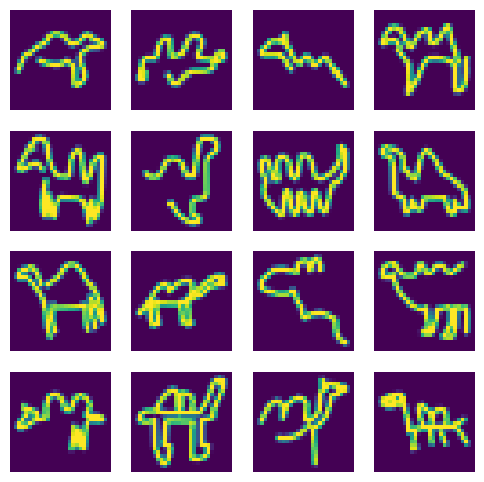

In [ ]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(6,6))
for i in range(16):
  plt.subplot(4,4,i+1)
  idx=(random.randint(0,data.shape[0]-1))
  plt.imshow(data[idx])
  plt.axis('off')
plt.show()

# costom dataset

In [ ]:
class cameldataset(Dataset):
  def __init__(self,array,transform=None):
    self.data=array
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    img=self.data[idx]
    if self.transform:
      img=self.transform(img)

    return img



# Dataloader

In [ ]:
dataset=cameldataset(data,transform=transform)
dataloader=DataLoader(dataset,batch_size=64,shuffle=True)

In [ ]:
for real in dataloader:
  print(real.shape)
  break

torch.Size([64, 1, 28, 28])


#discriminator

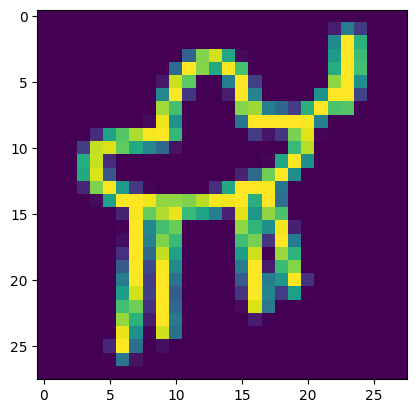

In [ ]:
img_ten=dataset[1]
img=img_ten.squeeze(0)
plt.imshow(img)

In [ ]:
class discriminator(nn.Module):
  def __init__(self,
               input_channel=1,
               conv_filters=[64,64,128,128],
               con_kernel_size=[5,5,5,5],
               con_strides=[2,2,2,1],
               con_paddings=[2,2,2,2],
               batch_norm_momentum=None,
               activation='relu',
               dropout_rate=0.4):
    super().__init__()
    layer=[]
    in_channel=input_channel

    # buiding stacked convolution
    for i in range(len(conv_filters)):
      layer.append(
          nn.Conv2d(in_channels=in_channel,
                    out_channels=conv_filters[i],
                    kernel_size=con_kernel_size[i],
                    stride=con_strides[i],
                    padding=con_paddings[i]
                    )
          )

      # batch normalization (shlipped for the first layer )
      if batch_norm_momentum is not None and i>0:
        layer.append(nn.BatchNorm2d(conv_filters[i],momentum=batch_norm_momentum))
      #activation
      if activation == 'relu':
        layer.append(nn.ReLU())

      elif activation == 'leaky_relu':
        layer.append(nn.LeakyReLU(0.2))

      if dropout_rate is not None:
        layer.append(nn.Dropout2d(dropout_rate))

      in_channel=conv_filters[i]

    self.conv_layer=nn.Sequential(*layer)
    # After conv layers:
        # Input image = 28x28
        # Stride 2 reduces size: 28 -> 14 -> 7 -> 4
        # Final tensor = (batch, 128, 4, 4)
    self.flatten=nn.Flatten()
    self.fc=nn.Sequential(
        nn.Linear(128*4*4,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    x=self.conv_layer(x)
    x=self.flatten(x)
    x=self.fc(x)
    return x


# Genereator

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self,
                 z_dim=100,
                 initial_shape=(64, 7, 7),
                 conv_filters=[128, 64, 64, 1],
                 conv_kernel_sizes=[5, 5, 5, 5],
                 batch_norm_momentum=0.9):

        super().__init__()
        self.fc=nn.Sequential(
            nn.Linear(z_dim,64*7*7),
            nn.BatchNorm1d(64*7*7,momentum=batch_norm_momentum),
            nn.ReLU()
            )
        self.initial_shape=initial_shape

        layer=[]
        input_channel=initial_shape[0]

        for i in range(len(conv_filters)):
          if i<2:
            layer.append(nn.Upsample(scale_factor=2,mode='nearest'))
          layer.append(
              nn.Conv2d(
                  in_channels=input_channel,
                  out_channels=conv_filters[i],
                  kernel_size=conv_kernel_sizes[i],
                  stride=1,
                  padding=2
              )
          )
          if i<len(conv_filters)-1:
              layer.append(nn.BatchNorm2d(conv_filters[i],momentum=batch_norm_momentum))
              layer.append(nn.ReLU())
          else:
              layer.append(nn.Tanh())
          input_channel=conv_filters[i]

        self.conv_layer=nn.Sequential(*layer)

    def forward(self,x):
      x=self.fc(x)
      x=x.view(x.shape[0],*self.initial_shape)
      x=self.conv_layer(x)
      return x



In [ ]:
generator = Generator().to(device)
discriminator = discriminator().to(device)

criterion = nn.BCELoss()

d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0008)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0004)


In [ ]:
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True


In [ ]:
def train_discriminator(real_image):
  batch_size=real_image.size(0)

  valid = torch.ones(batch_size,1).to(device)
  fake = torch.zeros(batch_size,1).to(device)
  # ======================================================
  # 1. Train on real images
  # ======================================================

  unfreeze(discriminator)
  d_optimizer.zero_grad()

  real_pred=discriminator(real_image)
  real_loss=criterion(real_pred,valid)

  # ======================================================
  # 2. Train on fake images
  # ======================================================

  z=torch.randn(batch_size,100).to(device)
  fake_image=generator(z).detach()

  fake_pred=discriminator(fake_image)
  fake_loss=criterion(fake_pred,fake)

  d_loss=real_loss+fake_loss
  d_loss.backward()
  d_optimizer.step()

  return d_loss.item()






In [ ]:
def train_generator(batch_size):
  valid=torch.ones(batch_size,1).to(device)

  freeze(discriminator)

  g_optimizer.zero_grad()

  z=torch.randn(batch_size,100).to(device)
  fake_image=generator(z)

  pred=discriminator(fake_image)
  g_loss=criterion(pred,valid)
  g_loss.backward()
  g_optimizer.step()

  return g_loss.item()

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# ---------------------------
# Parameters
# ---------------------------
batch_size = 64
epochs = 1 # start smaller to test
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ---------------------------
# Training loop
# ---------------------------
for epoch in range(epochs):
    d_losses = []
    g_losses = []

    # tqdm for batch-level progress
    for real_imgs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move images to device and convert to float
        real_imgs = real_imgs.to(device).float()

        # --- Train Discriminator ---
        d_loss = train_discriminator(real_imgs)
        d_losses.append(d_loss)

        # --- Train Generator ---
        g_loss = train_generator(real_imgs.size(0))
        g_losses.append(g_loss)

    # Compute average loss for the epoch
    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")


Epoch 1/1: 100%|██████████| 1897/1897 [1:51:56<00:00,  3.54s/it]

Epoch [1/1] | D Loss: 0.4255 | G Loss: 14.7407


In [ ]:
torch.save({
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'g_optimizer': g_optimizer.state_dict(),
    'd_optimizer': d_optimizer.state_dict(),
}, "gan_checkpoint.pth")


In [ ]:


# Load weights
generator.load_state_dict(torch.load("generator_epoch200.pth"))
discriminator.load_state_dict(torch.load("discriminator_epoch200.pth"))

# Set models to evaluation mode if generating images
generator.eval()
discriminator.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'generator_epoch200.pth'

#What is a Conditional GAN (cGAN)?

A Conditional Generative Adversarial Network (cGAN) is an extension of a standard GAN where additional information (a condition) is provided to both the Generator and Discriminator.

In a normal GAN:

Generator G learns to create fake data from random noise z

Discriminator D decides whether the data is real or fake

Standard GAN:
G(z) → fake image
D(x) → real or fake

🟣 How Conditional GAN is Different

In a cGAN, we add a condition y (label/class/attribute) to both G and D.

G(z | y) → fake image conditioned on label y
D(x | y) → classify image x as real or fake given label y


So instead of generating random images, the generator learns to generate images belonging to a specified class.

🔗 Architecture: How cGAN Works
Generator

Input = random noise z + class label y
Output = fake image belonging to class y

Discriminator

Input = image x + label y
Output = probability that x is real or fake

🧠 Why Add Condition?

To control what we generate.

GAN	cGAN
Uncontrolled image generation	Generation based on a specific class
Produces random objects	Produces what you request
No label input	Label (condition) provided

Example (Fashion-MNIST):

Ask the cGAN to generate y = 9 (shoes) → Generates shoe images

Ask y = 0 (T-shirt) → Generates T-shirts

🏗️ Mathematical Formulation

Standard GAN loss:

min_G max_D  E[log D(x)] + E[log (1 - D(G(z)))]


Conditional GAN loss:

min_G max_D  E[log D(x | y)] + E[log (1 - D(G(z | y)))]


Here:

(x | y) means discriminator sees real image x with label y

(G(z | y)) = generator makes new image conditioned on y

🎯 Benefits of cGAN
Benefit	Explanation
Controlled image generation	Generate specific classes
Better training stability	Condition gives more structure
More realistic images	Because generator learns class features
Flexible uses	Text → image, image → image, style transfer
🌍 Applications
Area	Examples
Image generation	Clothing, faces labeled by age/gender
Image-to-image	Pix2Pix, super resolution
Text-to-image	DALL·E, Stable Diffusion base concept
Medical	Generating tumor types
Satellite	Create images from labels or maps
🪄 Simple Analogy

Imagine GAN as a painter and critic:

Normal GAN

Painter draws anything randomly

Critic only checks real vs fake

Conditional GAN

You give painter instructions: “Draw shoes”

Critic checks: Is this a real shoe or fake shoe?

So cGAN gives more control and purpose.

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [ ]:
save_dir = "cgan_results"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] range automatically
    transforms.Normalize((0.5),(0.5)) # Scales to [-1, 1]
    #normalized_tensor = (tensor - mean) / std
])


In [ ]:
dataset=datasets.FashionMNIST(root="./data",train=True , download=True, transform=transform)
dataloader=DataLoader(dataset,batch_size=128,shuffle=True)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.42MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 143kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.65MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


In [ ]:
image,label=dataset[0]
print(image.shape,label)

torch.Size([1, 28, 28]) 9


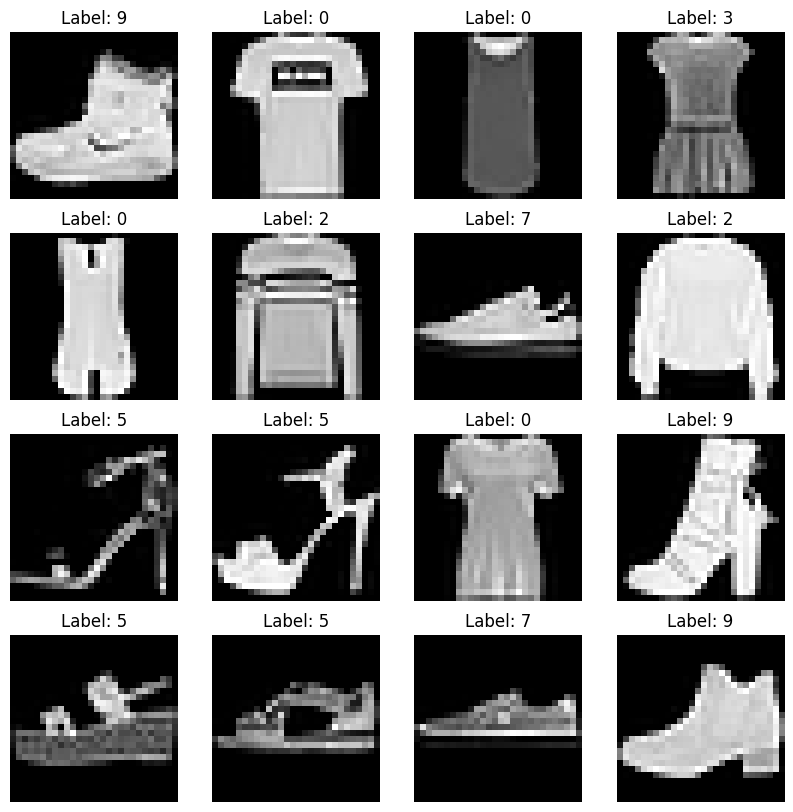

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(16):
  image,label = dataset[i]
  plt.subplot(4,4,i+1)
  plt.imshow(image.squeeze(),cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')
plt.show()


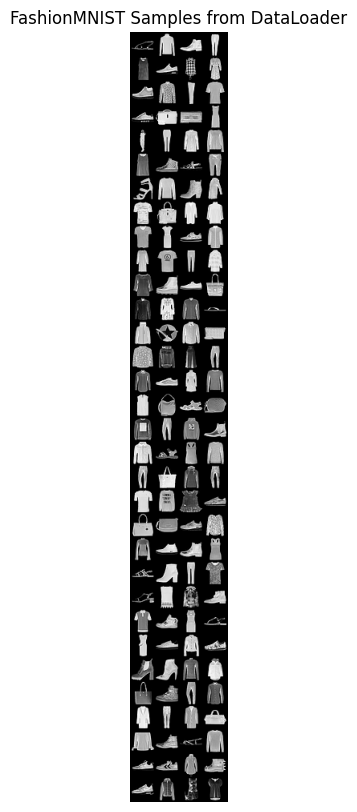

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
# Get a batch from dataloader
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Take first 16 images

# Create grid
grid = vutils.make_grid(images, nrow=4, normalize=True)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('FashionMNIST Samples from DataLoader')
plt.show()

In [ ]:
class discriminator(nn.Module):
  def __init__(self,
               num_classes=10,
               input_channel=1,
               conv_filters=[64,64,128,128],
               con_kernel_size=[5,5,5,5],
               con_strides=[2,2,2,1],
               con_paddings=[2,2,2,2],
               batch_norm_momentum=None,
               activation='relu',
               dropout_rate=0.4):
    super().__init__()
    self.layer_em=nn.Embedding(num_classes,28*28)
    layer=[]
    in_channel=input_channel+1

    # buiding stacked convolution
    for i in range(len(conv_filters)):
      layer.append(
          nn.Conv2d(in_channels=in_channel,
                    out_channels=conv_filters[i],
                    kernel_size=con_kernel_size[i],
                    stride=con_strides[i],
                    padding=con_paddings[i]
                    )
          )

      # batch normalization (shlipped for the first layer )
      if batch_norm_momentum is not None and i>0:
        layer.append(nn.BatchNorm2d(conv_filters[i],momentum=batch_norm_momentum))
      #activation
      if activation == 'relu':
        layer.append(nn.ReLU())

      elif activation == 'leaky_relu':
        layer.append(nn.LeakyReLU(0.2))

      if dropout_rate is not None:
        layer.append(nn.Dropout2d(dropout_rate))

      in_channel=conv_filters[i]

    self.conv_layer=nn.Sequential(*layer)
    # After conv layers:
        # Input image = 28x28
        # Stride 2 reduces size: 28 -> 14 -> 7 -> 4
        # Final tensor = (batch, 128, 4, 4)
    self.flatten=nn.Flatten()
    self.fc=nn.Sequential(
        nn.Linear(128*4*4,1),
        nn.Sigmoid()
    )
  def forward(self,x,label):
    label_embedding=self.layer_em(label)
    label_embedding=label_embedding.view(label_embedding.shape[0],1,28,28)
    # Concatenate label channel & image channels
    x=torch.cat([x,label_embedding],dim=1)


    x=self.conv_layer(x)
    x=self.flatten(x)
    x=self.fc(x)
    return x


In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self,
                 z_dim=100,
                 num_classes=10,
                 embedding_dim=100,
                 initial_shape=(64, 7, 7),
                 conv_filters=[128, 64, 64, 1],
                 conv_kernel_sizes=[5, 5, 5, 5],
                 batch_norm_momentum=0.9):

        super().__init__()
        self.layer_em=nn.Embedding(num_classes,100)
        self.fc=nn.Sequential(
            nn.Linear(z_dim + embedding_dim,64*7*7),
            nn.BatchNorm1d(64*7*7,momentum=batch_norm_momentum),
            nn.ReLU()
            )
        self.initial_shape=initial_shape

        layer=[]
        input_channel=initial_shape[0]

        for i in range(len(conv_filters)):
          if i<2:
            layer.append(nn.Upsample(scale_factor=2,mode='nearest'))
          layer.append(
              nn.Conv2d(
                  in_channels=input_channel,
                  out_channels=conv_filters[i],
                  kernel_size=conv_kernel_sizes[i],
                  stride=1,
                  padding=2
              )
          )
          if i<len(conv_filters)-1:
              layer.append(nn.BatchNorm2d(conv_filters[i],momentum=batch_norm_momentum))
              layer.append(nn.ReLU())
          else:
              layer.append(nn.Tanh())
          input_channel=conv_filters[i]

        self.conv_layer=nn.Sequential(*layer)

    def forward(self,x,label):
      label_embedding=self.layer_em(label)
      #concatinating noice+embedding
      x=torch.cat([x,label_embedding],dim=1)
      x=self.fc(x)
      x=x.view(x.shape[0],*self.initial_shape)
      x=self.conv_layer(x)
      return x



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
generator = Generator().to(device)
discriminator = discriminator().to(device)

criterion = nn.BCELoss()

d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0008)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0004)


In [ ]:
def freeze(model):
  for p in model.parameters():
    p.requires_grad=False

def unfreeze(model):
  for p in model.parameters():
    p.requires_grad=True

In [ ]:
def train_discriminator(real_imgs, labels):
    batch_size = real_imgs.size(0)

    valid = torch.ones(batch_size, 1).to(device)
    fake = torch.zeros(batch_size, 1).to(device)

    unfreeze(discriminator)
    d_optimizer.zero_grad()

    # --- real loss ---
    real_preds = discriminator(real_imgs, labels)
    real_loss = criterion(real_preds, valid)

    # --- fake loss ---
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
    fake_imgs = generator(z, fake_labels).detach()       # important: detach!

    fake_preds = discriminator(fake_imgs, fake_labels)
    fake_loss = criterion(fake_preds, fake)

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

In [ ]:
def train_generator(batch_size):

  valid=torch.ones(batch_size,1).to(device)

  freeze(discriminator)
  g_optimizer.zero_grad()

  z=torch.rand(batch_size,100).to(device)
  gen_labels=torch.randint(0,10,(batch_size,)).to(device)
  gen_image=generator(z,gen_labels)

  pred=discriminator(gen_image,gen_labels)
  g_loss=criterion(pred,valid)
  g_loss.backward()
  g_optimizer.step()

  return g_loss.item(),gen_image


In [ ]:
print(device)
torch.cuda.is_available()


cpu


False

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
epochs=10
d_losses = []
g_losses = []

for epoch in range(epochs):
    d_epoch_loss = 0.0
    g_epoch_loss = 0.0

    for real_imgs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Train discriminator
        d_loss = train_discriminator(real_imgs, labels)
        d_epoch_loss += d_loss

        # Train generator
        g_loss,gen_imgs = train_generator(batch_size)
        g_epoch_loss += g_loss

    # Average loss for epoch
    d_losses.append(d_epoch_loss / len(dataloader))
    g_losses.append(g_epoch_loss / len(dataloader))

    print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_losses[-1]:.4f} G_loss: {g_losses[-1]:.4f}")
    torchvision.utils.save_image(gen_imgs[:25], f"{save_dir}/epoch_{epoch+1}.png", nrow=5, normalize=True)



Epoch 1/10:   0%|          | 0/469 [00:04<?, ?it/s]


KeyboardInterrupt: 

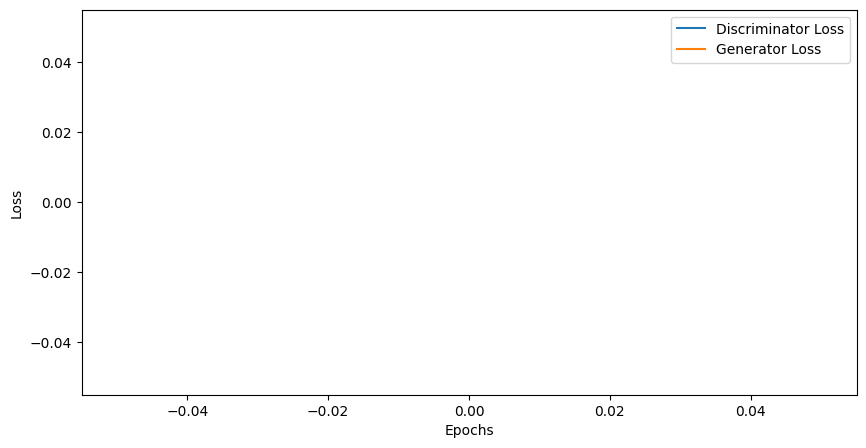

In [ ]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_dir = "/content/drive/MyDrive/GAN_Project"
os.makedirs(save_dir, exist_ok=True)


In [ ]:
torch.save(generator.state_dict(), os.path.join(save_dir, "generator_epoch_{}.pth".format(epoch+1)))
torch.save(discriminator.state_dict(), os.path.join(save_dir, "discriminator_epoch_{}.pth".format(epoch+1)))


In [ ]:
import pickle
# After updating the loss lists at the end of each epoch:
with open(os.path.join(save_dir, "D_losses.pkl"), "wb") as f:
    pickle.dump(d_losses, f)

with open(os.path.join(save_dir, "G_losses.pkl"), "wb") as f:
    pickle.dump(g_losses, f)

In [ ]:
generator.load_state_dict(torch.load(
    "/content/drive/MyDrive/GAN_Project/generator_epoch_10.pth",
    map_location=torch.device('cpu')
))
generator.to(device)  # 'device' can still be cpu or gpu
generator.eval()


Generator(
  (layer_em): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=3136, bias=True)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_layer): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): T

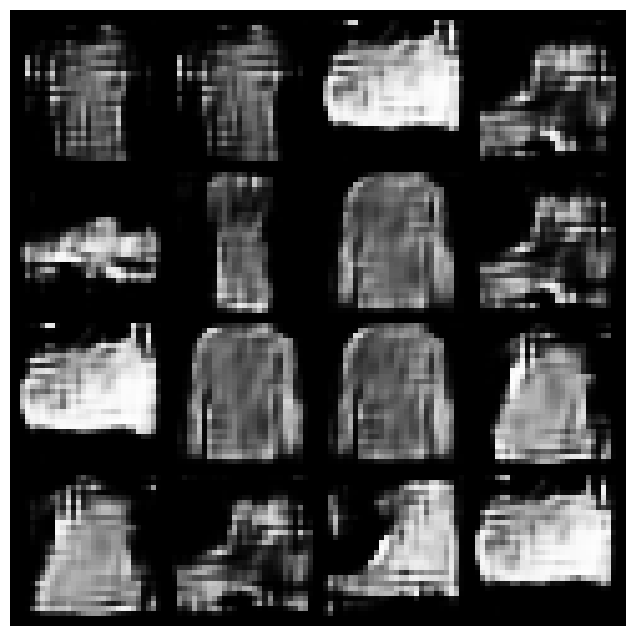

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Parameters
z_dim = 100
num_classes = 10
batch_size = 16  # number of images to generate

# Generate random noise and labels
z = torch.randn(batch_size, z_dim).to(device)
labels = torch.randint(0, num_classes, (batch_size,)).to(device)

# Generate images
with torch.no_grad():
    gen_imgs = generator(z, labels)

# Convert tensor to numpy for plotting
grid_img = vutils.make_grid(gen_imgs, nrow=4, normalize=True).cpu()
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC
plt.axis('off')
plt.show()


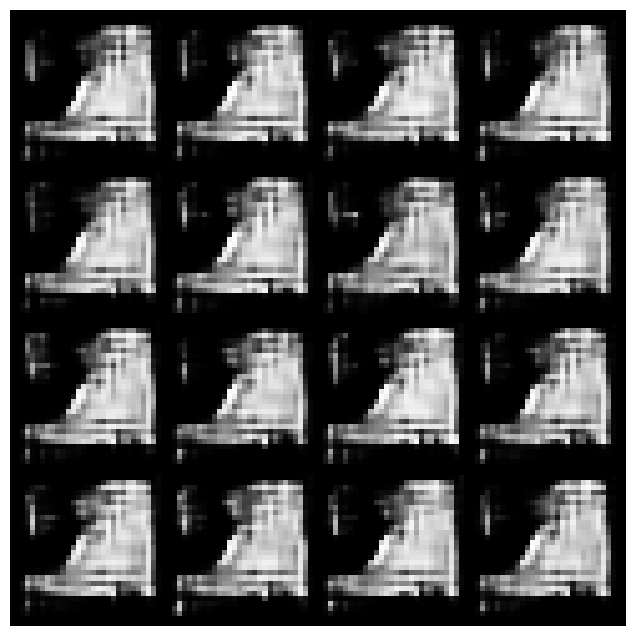

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Parameters
z_dim = 100
num_classes = 10
batch_size = 16  # number of images to generate
target_class = 9  # change this to the class you want (0-9 for FashionMNIST)

# Generate random noise
z = torch.randn(batch_size, z_dim).to(device)

# Create labels for the specific class
labels = torch.full((batch_size,), target_class, dtype=torch.long).to(device)

# Generate images
with torch.no_grad():
    gen_imgs = generator(z, labels)

# Plot images in a grid
grid_img = vutils.make_grid(gen_imgs, nrow=4, normalize=True).cpu()
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC
plt.axis('off')
plt.show()


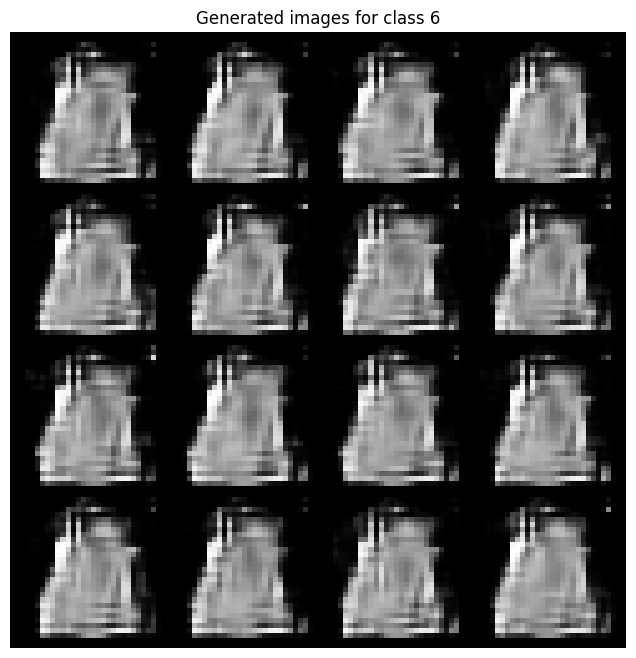

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

batch_size = 16   # number of images you want
target_class = 6  # e.g., 0 for "T-shirt" in FashionMNIST

# Random noise for each image
z = torch.randn(batch_size, z_dim).to(device)

# All labels are the same
labels = torch.full((batch_size,), target_class, dtype=torch.long).to(device)

# Generate images
with torch.no_grad():
    gen_imgs = generator(z, labels)

# Visualize
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title(f"Generated images for class {target_class}")
plt.imshow(vutils.make_grid(gen_imgs, nrow=4, normalize=True).permute(1,2,0).cpu())
plt.show()
